# U.S. Patent Phrase to Phrase Matching
This is a notebook for the [U.S. Patent Phrase to Phrase Matching competition](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching) based on:
* [Jeremy Howard's notebook](https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster)
* [Nayak Roshan's notebook](https://www.kaggle.com/code/nayakroshan/uspppm-pytorch-lightning)
* [Y. Nakama's notebook](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train/notebook)
This is the inference step. The training step is [here](https://www.kaggle.com/code/edmundtang/uspppm-01-training/edit/run/97244433).

## Libraries

In [1]:
import gc
import re
import time
import math
import random
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
from scipy import stats
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


## Configuration (CFG)

In [2]:
class CFG:
    model_type = 'bert' # ['bert', 'deberta']
    model_name = 'anferico/bert-for-patents' # ['anferico/bert-for-patents' ''../input/bert-for-patent/bert-for-patents/', 'microsoft/deberta-v3-large']
    path = '../input/patentbert01/' 
    config_path = path + 'config.pth'
    max_len = 150
    val_size = 0.25
    seed = 42
    batch_size = 16
    num_workers = 4
    encoder_lr = 2e-5
    decoder_lr = 2e-5
    weight_decay = 0.01
    eps = 1e-6
    betas = (0.9, 0.999)
    num_cycles=0.5
    num_warmup_steps = 0
    scheduler = 'cosine' # ['linear','cosine']
    batch_scheduler = True
    fc_dropout = 0.20
    target_size = 1
    epochs = 3
    train = True
    apex = True
    gradient_accumulation_steps = 1
    max_grad_norm = 1000
    print_freq = 50
    debug = False
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

## Directory Settings

In [3]:
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    !pip install -q datasets
import datasets
from datasets import load_dataset, Dataset, DatasetDict
INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [4]:
def get_score(y_true, y_pred):
    score = stats.pearsonr(y_true, y_pred)[0]
    return score

In [5]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=CFG.seed)

## Data Loading

In [6]:
test_df = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"test.shape: {test_df.shape}")
print(f"submission.shape: {submission.shape}")
display(test_df.head())
display(submission.head())

test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [7]:
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results

cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
test_df['context_text'] = test_df['context'].map(cpc_texts)
display(test_df.head())

,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


## Tokenizer

In [8]:
tokz = AutoTokenizer.from_pretrained(CFG.path + 'tokenizer')
tokz.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokz
print(tokz.all_special_tokens)
sep = tokz.sep_token
print(sep)

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']
[SEP]


In [9]:
test_df['inputs'] = test_df.anchor + sep + test_df.target + sep + test_df.context_text
display(test_df.head())

,id,anchor,target,context,context_text,inputs
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


## Build Dataset

In [10]:
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

class TestDataset(Dataset):
    def __init__(self, cfg, ds):
        self.cfg = cfg
        self.inputs = ds['inputs']
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.inputs[item])
        return inputs

In [11]:
test_ds = Dataset.from_pandas(test_df)
test_dataset = TestDataset(CFG, test_ds)
test_loader = DataLoader(test_dataset,
                         batch_size=CFG.batch_size, shuffle=False,
                         num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

## Load Model

In [12]:
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model_name, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if CFG.model_type == 'deberta':
            if pretrained:
                self.model = AutoModel.from_pretrained(cfg.model_name, config=self.config)
            else:
                self.model = AutoModel.from_config(self.config)
            self.fc_dropout = nn.Dropout(cfg.fc_dropout)
            self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
            self._init_weights(self.fc)
            self.attention = nn.Sequential(
                nn.Linear(self.config.hidden_size, 512),
                nn.Tanh(),
                nn.Linear(512, 1),
                nn.Softmax(dim=1)
            )
            self._init_weights(self.attention)
        elif CFG.model_type == 'bert':
            if pretrained:
                self.model = AutoModel.from_pretrained(cfg.model_name, config=self.config)
            else:
                self.model = AutoModel.from_config(self.config)
            self.head = nn.Linear(self.config.hidden_size, 1, bias=True)
            self.dropout = nn.Dropout(0.5)
            
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, inputs):
        if CFG.model_type == 'deberta':
            outputs = self.model(**inputs)
            last_hidden_states = outputs[0]
            # feature = torch.mean(last_hidden_states, 1)
            weights = self.attention(last_hidden_states)
            feats = torch.sum(weights * last_hidden_states, dim=1)
            output = self.fc(self.fc_dropout(feats))
        elif CFG.model_type == 'bert':
            feats = self.model(**inputs)
            feats = torch.sum(feats[0], 1)/feats[0].shape[1]
            feats = self.dropout(feats)
            output = self.head(feats)
        return output

In [13]:
def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [14]:
predictions = []
model = CustomModel(CFG, config_path=CFG.config_path, pretrained = False)
state = torch.load(CFG.path+f"{CFG.model_name.replace('/', '-')}_best.pth",
                  map_location=torch.device('cpu'))
model.load_state_dict(state['model'])
prediction = inference_fn(test_loader, model, device)
predictions.append(prediction)

predictions = np.mean(predictions,axis=0)

  0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
display(predictions)

array([[4.9840662e-01],
       [6.4862382e-01],
       [4.6567169e-01],
       [2.7261868e-01],
       [1.2427785e-04],
       [5.0456631e-01],
       [4.6697956e-01],
       [1.4561992e-04],
       [2.4437392e-01],
       [9.9858898e-01],
       [2.7178407e-01],
       [2.6364738e-01],
       [7.5953579e-01],
       [8.7590289e-01],
       [7.6441365e-01],
       [2.8777254e-01],
       [3.1547588e-01],
       [1.3133351e-04],
       [4.6362427e-01],
       [4.0322927e-01],
       [4.2006066e-01],
       [2.5187093e-01],
       [2.7964514e-01],
       [2.4864565e-01],
       [5.1183647e-01],
       [1.2067416e-04],
       [6.8892172e-05],
       [7.1039583e-05],
       [2.1960847e-04],
       [6.8790501e-01],
       [2.1251523e-01],
       [1.4590763e-04],
       [7.6559198e-01],
       [5.7012039e-01],
       [2.4984114e-01],
       [2.7074209e-01]], dtype=float32)

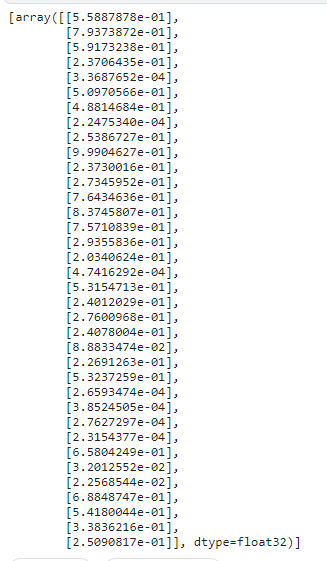


In [16]:
submission['score'] = predictions
display(submission.head())
submission[['id', 'score']].to_csv('submission.csv', index=False)

,id,score
0,4112d61851461f60,0.498407
1,09e418c93a776564,0.648624
2,36baf228038e314b,0.465672
3,1f37ead645e7f0c8,0.272619
4,71a5b6ad068d531f,0.000124
